In [174]:
import sys
import importlib
import re

import torch
import numpy as np
import pandas as pd

import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib.animation as animation

sys.path.append('../Scripts/')
import PINN_moredim
import data

importlib.reload(PINN_moredim)
importlib.reload(data)
from PINN_moredim import load_data, PINN_inference, generate_data, DiffEquation, load_moredim, load_data_neumann
from data import load_csv_data

# from train import train

import warnings
warnings.filterwarnings("ignore")

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(42)

In [175]:
import yaml

# Load the YAML file
with open('../Config/config_pde_2d.yaml', 'r') as file:
    config = yaml.safe_load(file)

# Automatically create variables from the YAML keys
for key, value in config.items():
    for k, v in value.items():
        globals()[k] = v


## Parameters

## Equation and Conditions

## Data Load

In [176]:


diff_equation = DiffEquation(equation=equation, func_to_optimize=func_to_optimize, hidden_layers=[300, 100], activation='sigmoid')

diff_equation.set_constants(constant_values)


In [177]:
# Keep in mind that when using neumann, you have to define the solution in the PINN_moredim.py file
bc_type = 'diri'
if diff_equation.dx:
    for eq in initial_conditions:
        if 'ud' in eq:
            bc_type = 'neumann'

In [178]:
if data_from_csv:
    data = load_csv_data(diff_equation, data_from_csv, params_to_optimize=params_to_optimize)
else:
    if diff_equation.dx: # If PDE

        if diff_equation.dy: # 2D
            data = load_moredim(diff_equation, f, params_to_optimize=params_to_optimize, L=L, T=T, plate_length=plate_length, max_iter_time=max_iter_time)

        elif bc_type == 'neumann': # Neumann BC
            data = load_data_neumann(diff_equation, f, params_to_optimize, L_min, L, T, N_train)

        else: # Dirichlet BC
            # data = load_data_neumann(diff_equation, f, params_to_optimize, L_min, L, T, N_train)
            data = generate_data(diff_equation, params_to_optimize=params_to_optimize, L_min=L_min, L=L, T=T, N_train=N_train, N_test=N_test, initial_conditions=initial_conditions)
    
    else: # If ODE
        data = load_data(diff_equation, params_to_optimize=params_to_optimize, initial_conditions=initial_conditions, t_0=t_0, t_fin=t_fin, n_points=n_points, noise=noise)


## Training

In [179]:

torch.manual_seed(42)
# Inicializar los modelos y el optimizador
pinn_inf_model = PINN_inference(params=params_to_optimize, input_size=data[2].shape[1], hidden_layers=layers, activation=activations, bc_type=bc_type, data_from_csv=data_from_csv).to(DEVICE)
# pinn_inf_model = PINN_inference(params=params_to_optimize, input_size=data[2].shape[1], hidden_layers=layers, activation=activations, bc_type=bc_type).to(DEVICE)


Using LBFGS
Epoch: 0, Loss: 0.21226416528224945, MSE Loss: 0.01630811206996441, Physics Loss: 0.001244465121999383, Validation Loss: 0.06957586109638214
Epoch: 10, Loss: 0.20169895887374878, MSE Loss: 0.01376666035503149, Physics Loss: 0.009455688297748566, Validation Loss: 0.07382028549909592
Epoch: 20, Loss: 0.17438429594039917, MSE Loss: 0.011661170981824398, Physics Loss: 0.012023938819766045, Validation Loss: 0.06323748081922531
Epoch: 30, Loss: 0.08109645545482635, MSE Loss: 0.009431430138647556, Physics Loss: 0.0038306538481265306, Validation Loss: 0.010780620388686657
Epoch: 40, Loss: 0.0409565307199955, MSE Loss: 0.003511906135827303, Physics Loss: 0.012399000115692616, Validation Loss: 0.003132252022624016
Epoch: 50, Loss: 0.016856208443641663, MSE Loss: 0.0008423670660704374, Physics Loss: 0.009775148704648018, Validation Loss: 0.0006079631857573986
Epoch: 60, Loss: 0.01220006588846445, MSE Loss: 0.000481851544464007, Physics Loss: 0.008035033009946346, Validation Loss: 0.00

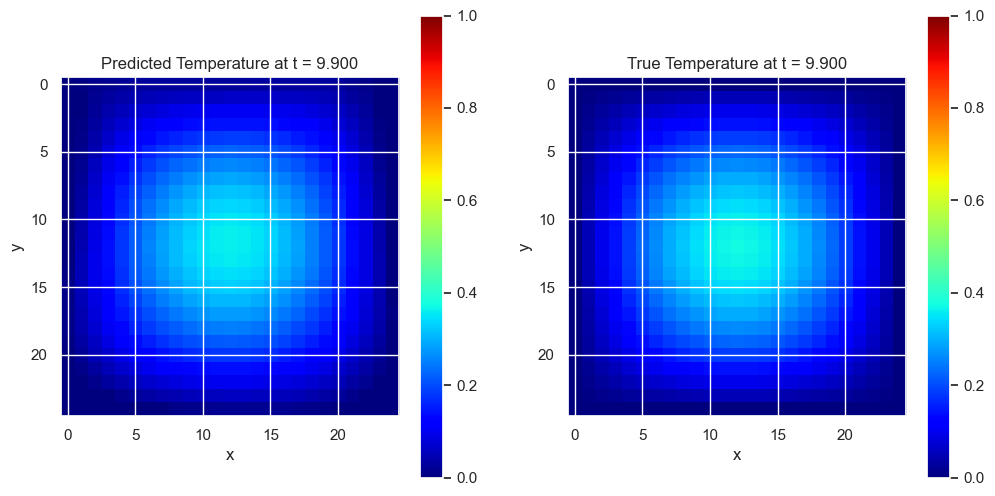

In [180]:
# Entrenar el modelo
pinn_inf_model.train(
    data=data,
    diff_equation=diff_equation,
    constant_values=diff_equation.constants,
    initial_conditions=initial_conditions,
    lr=lr,
    n_epochs=n_epochs,
    optimizer_name=optimizer,
    lambda_pin=lambda_pin,
    lambda_ic=lambda_ic,
    lambda_bc=lambda_bc,
)

for constant in pinn_inf_model.params:
    print(constant, getattr(pinn_inf_model, constant).item())


# Plot the results
if diff_equation.dy:
    pinn_inf_model.plot_2d(data)
elif diff_equation.dx and not diff_equation.dy:
    pinn_inf_model.plot_solution(data)
elif not diff_equation.dx:
    pinn_inf_model.plot(data)



## 2D visualization

In [181]:
# train_t = np.linspace(0, T, max_iter_time)

# u_pred = pinn_inf_model(data[2]).reshape(len(train_t), plate_length, plate_length).detach().numpy()
# u_true = data[3].reshape(len(train_t), plate_length, plate_length).detach().numpy()
# t = -1

# fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# ax1, ax2 = axs

# im1 = ax1.imshow(u_pred[t, :, :], cmap=plt.cm.jet, vmin=0, vmax=1)
# im2 = ax2.imshow(u_true[t, :, :], cmap=plt.cm.jet, vmin=0, vmax=1)

# # Add colorbars to both subplots
# fig.colorbar(im1, ax=ax1)
# fig.colorbar(im2, ax=ax2)

# # Set initial titles and labels
# ax1.set_title(f'Predicted Temperature at t = {0.1 * (t % max_iter_time)}')
# ax1.set_xlabel('x')
# ax1.set_ylabel('y')

# ax2.set_title(f'True Temperature at t = {0.1 * (t % max_iter_time)}')
# ax2.set_xlabel('x')
# ax2.set_ylabel('y')
# plt.show()

# Functional Inference

Check if the function has been learnt

In [182]:
if func_to_optimize:
    temps = pinn_inf_model(data[2])
    data[2].requires_grad = True
    P_stack_dT = diff_equation()(data[2], temps).detach().numpy()

    if not diff_equation.dx:
        plt.plot(data[2].detach().numpy(), P_stack_dT, 'g--', label='p_stack - dT')
        plt.plot(data[2].detach().numpy(), [0 for _ in range(len(data[2].detach().numpy()))], 'r--', label='0')
        plt.legend()
        plt.show()
    else:
        # Crear Scatter3d para datos de entrenamiento y prueba
        num_test_divisions = int(np.sqrt(len(P_stack_dT)))
        t_test = np.linspace(0, data[2][-1, 0].item(), num_test_divisions)
        x_test = np.linspace(0, data[2][-1, 1].item(), num_test_divisions)
        u_test = P_stack_dT.reshape((num_test_divisions, num_test_divisions))
        scatter_test = go.Scatter3d(
            x=data[2][:, 1].detach().numpy(),
            y=data[2][:, 0].detach().numpy(),
            z=P_stack_dT[:, 0],
            mode="markers",
            marker=dict(size=4, opacity=0.5, color="blue"),
            name="test Data",
        )

        y_pred = P_stack_dT
        u_test = y_pred.reshape((num_test_divisions, num_test_divisions))
        scatter_pred = go.Scatter3d(
            x=data[2][:, 1].detach().numpy(),
            y=data[2][:, 0].detach().numpy(),
            z=y_pred[:, 0],
            mode="markers",
            marker=dict(size=2, opacity=0.35, color="red"),
            name="Test Data",
        )

        # Crear la superficie para la función subyacente
        surface_true = go.Surface(
            x=t_test,
            y=x_test,
            z=u_test,
            opacity=0.5,
            colorscale="Blues",
            showscale=False,
            name="True Function",
        )
        surface_pred = go.Surface(
            x=t_test,
            y=x_test,
            z=u_test,
            opacity=0.5,
            colorscale="Blues",
            showscale=False,
            name="True Function",
        )

        # Crear el gráfico
        fig = go.Figure(data=[scatter_test, scatter_pred, surface_true, surface_pred])
        fig.update_layout(
            scene=dict(
                xaxis_title="t",
                yaxis_title="x",
                zaxis_title="u(t,x)",
                aspectmode="cube",
            ),
            width=1000,  # Cambia el ancho de la figura
            height=800,
            legend=dict(x=-0.1, y=1.0, font=dict(size=16)),
        )  # Ajusta el tamaño del texto de la leyenda
        fig.show()